# Store Sales - Time Series Forecasting

### Contexto:

Los pronósticos no solo se limitan a la meteorología. Los gobiernos pronostican crecimiento económico. Los científicos intentan predecir la población futura. Y las empresas pronostican la demanda de productos, es una tarea común de los científicos de datos profesionales. Los pronósticos son especialmente relevantes para las tiendas de abarrotes tradicionales, que deben escoger delicadamente la cantidad de inventario que se debe comprar. Para predecir un mayor precisión que productos deben comprar y en cuantas cantidades. Adivinar los artículos populares que se agotan rápidamente no es muy eficiente, esto puede generar una pérdida de ingresos y clientes molestos. Gracias al aprendizaje automático, se puede ayudar a garantizar a que los clientes pueda tener suficientes productos correctos en el momento correcto, sosu.

Los métodos actuales de pronóstico subjetivo para el comercio minorista tienen pocos datos que los respalden y es poco probable que se automaticen. El problema se vuelve aún más complejo a medida que los minoristas agregan nuevas ubicaciones con necesidades únicas, nuevos productos, gustos estacionales en constante transición y marketing de productos impredecible, sosu.


### Meta:

Con lo anterior en mente debemos construir un modelo que prediga con mayor precisión las ventas unitarias de miles de artículos vendidos en diferentes tiendas Favorita, sosu. Practicará sus habilidades de aprendizaje automático con un conjunto de datos de capacitación accesible de fechas, tiendas e información de artículos, promociones y ventas de unidades, sosu.

<br>

<div align="center"><img width="500" height="500" src='https://upload.wikimedia.org/wikipedia/commons/0/0f/Corporaci%C3%B3n_Favorita_Logo.png'></div>

<br>

### Equipo Cortesanas de IA:
* Leonardo Alvarado
* Oscar Delgadillo
* David Guzmán
* Enrique Santos

### Proceso:

Todos los cambios realizados el la tabla de train, se haran sobre la tabla de test, para que asi, tengamos los mismos campos con el mismo tipo de variables tanto en la tabla de train como en la de test  

In [1]:
# Import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os

# Import regression and statmodels libraries
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer

# pandas dataframe configurations
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.4f}'.format

### Obtención de las tablas que se usaran para el modelo 

In [2]:
df_train = pd.read_csv("../input/store-sales-time-series-forecasting/train.csv")
df_test = pd.read_csv("../input/store-sales-time-series-forecasting/test.csv")
df_holidays_events = pd.read_csv("../input/store-sales-time-series-forecasting/holidays_events.csv")
df_oil = pd.read_csv("../input/store-sales-time-series-forecasting/oil.csv")

Hacemos un merge de los datos segun las fechas de las tablas holidays events, oil y train, para manipular todos los datos que se aplicaran en el modelo.

In [3]:
aux_train = pd.merge(df_train, df_holidays_events,on='date',how='left')
train = pd.merge(aux_train, df_oil,on='date',how='left')
aux_test = pd.merge(df_test, df_holidays_events,on='date',how='left')
test = pd.merge(aux_test, df_oil,on='date',how='left')
train

,id,date,store_nbr,family,sales,onpromotion,type,locale,locale_name,description,transferred,dcoilwtico
0,0,2013-01-01,1,AUTOMOTIVE,0.0000,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN
1,1,2013-01-01,1,BABY CARE,0.0000,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN
2,2,2013-01-01,1,BEAUTY,0.0000,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN
3,3,2013-01-01,1,BEVERAGES,0.0000,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN
4,4,2013-01-01,1,BOOKS,0.0000,0,Holiday,National,Ecuador,Primer dia del ano,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
3054343,3000883,2017-08-15,9,POULTRY,438.1330,0,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.5700
3054344,3000884,2017-08-15,9,PREPARED FOODS,154.5530,1,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.5700
3054345,3000885,2017-08-15,9,PRODUCE,2419.7290,148,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.5700
3054346,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.0000,8,Holiday,Local,Riobamba,Fundacion de Riobamba,False,47.5700


Al mergear la tabla "holidays events" con "train" y "test", nos quedan registros vacios (nan) en la columna de 'type' por lo que cambiamos estos por 0's

In [4]:
train['type'] = train['type'].fillna(0)
test['type'] = test['type'].fillna(0)

Al resto de los datos de esta columna los cambiamos por 1's, para asi tener como registro si ese dia es de vacaciones o no

In [5]:
train.type = train.type.replace(['Holiday', 'Event', 'Additional', 'Transfer', 'Work Day', 'Bridge'], 1)
test.type = test.type.replace(['Holiday', 'Event', 'Additional', 'Transfer', 'Work Day', 'Bridge'], 1)

Graficamos los datos de las ventas promedio en la historia.

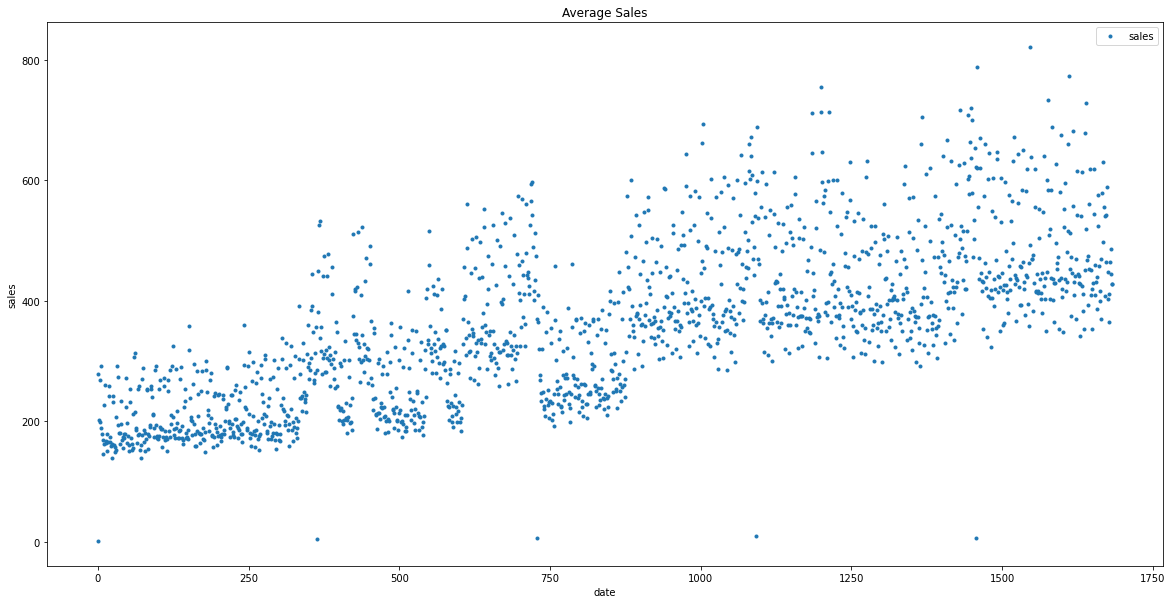

In [6]:
average_sales = train.groupby('date').mean()['sales'].to_frame().reset_index()

# Date se gráfica en base a su indice, porque son muchas fechas las que se deben gráficar
average_sales.plot(style='.', figsize=(20,10), title='Average Sales', xlabel='date', ylabel='sales');

Realizamos una winzorizacion de los datos de la columna 'sales', ya que en estos hay registros con valores muy altos o muy bajos, que hacen que el modelo sea menos preciso

In [7]:
from scipy.stats.mstats import winsorize
train["sales"] = winsorize(train["sales"], limits=[0.0001, 0.2])

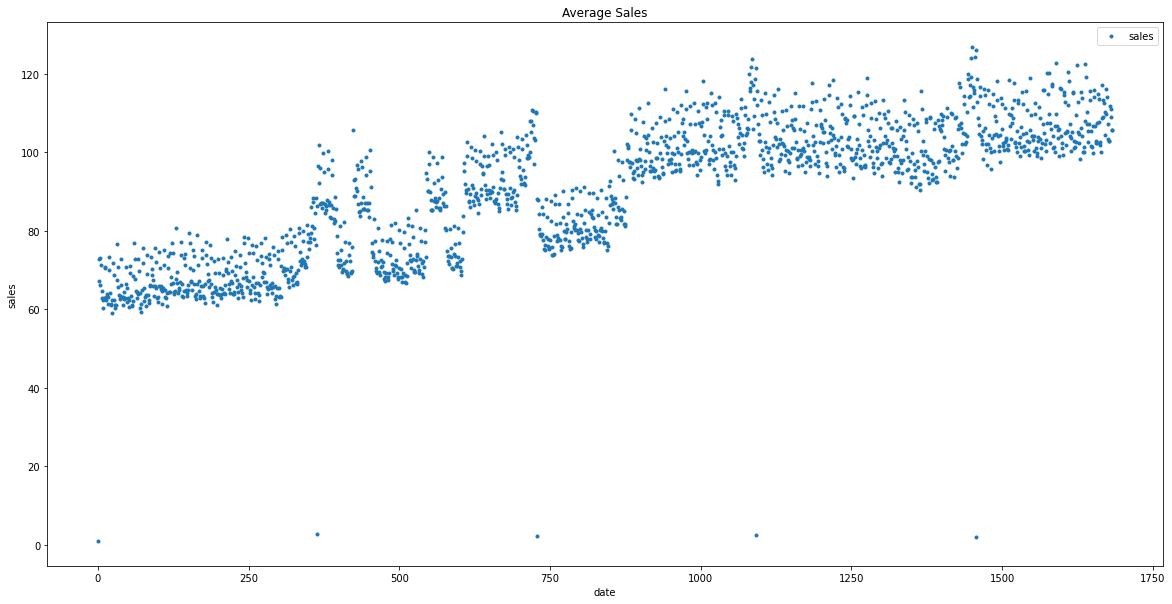

In [8]:
# Date se gráfica en base a su indice, porque son muchas fechas las que se deben gráficar
average_winzoriced_sales = train.groupby('date').mean()['sales'].to_frame().reset_index()
average_winzoriced_sales.plot(style='.', figsize=(20,10), title='Average Sales', xlabel='date', ylabel='sales');

Llenamos los valores N/A de la columna de dcoilwtico

In [9]:
#Filling the na values with the median othe the whole column
si = SimpleImputer(missing_values=np.nan, strategy="median")
si.fit(train[['dcoilwtico']])
si.fit(test[['dcoilwtico']])

#Filling missing data with median
train['dcoilwtico'] = si.transform(train[['dcoilwtico']])
test['dcoilwtico'] = si.transform(test[['dcoilwtico']])

Cambiamos los valores de "family" por valores numericos para el analisis del modelo

In [10]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()  
family_labels = label_encoder.fit_transform(train['family'])

label_encoder_test = LabelEncoder() 
family_labels_test = label_encoder_test.fit_transform(test['family'])

train['family'] = family_labels
test['family'] = family_labels_test

Cambiamos los valores de "locale" por valores numericos para el analisis del modelo

In [11]:
label_encoder = LabelEncoder()  
locale_labels = label_encoder.fit_transform(train['locale'])

label_encoder_test = LabelEncoder() 
locale_labels_test = label_encoder_test.fit_transform(test['locale'])

train['locale'] = locale_labels
test['locale'] = locale_labels_test

Cambiamos los valores de "locale_name" por valores numericos para el analisis del modelo

In [12]:
label_encoder = LabelEncoder()  
locale_name_labels = label_encoder.fit_transform(train['locale_name'])

label_encoder_test = LabelEncoder() 
locale_name_labels_test = label_encoder_test.fit_transform(test['locale_name'])

train['locale_name'] = locale_name_labels
test['locale_name'] = locale_name_labels_test

Cambiamos los valores de "description" por valores numericos para el analisis del modelo

In [13]:
label_encoder = LabelEncoder()  
description_labels = label_encoder.fit_transform(train['description'])

label_encoder_test = LabelEncoder() 
description_labels_test = label_encoder_test.fit_transform(test['description'])

train['description'] = description_labels
test['description'] = description_labels_test

Hacemos un análisis de multicolinearidad para sabe si hay fuerte correlación entre variables explicativas del modelo.

In [14]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()

vif  = train[["store_nbr", 'family', 'onpromotion', 'type', 'locale', 'locale_name', 'description', 'dcoilwtico']]

vif_data["feature"] = vif.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(vif.values, i) for i in range(len(vif.columns))]

print(vif_data)

       feature      VIF
0    store_nbr   4.0817
1       family   3.8046
2  onpromotion   1.0618
3         type   2.4697
4       locale 121.6755
5  locale_name  43.2882
6  description  98.3369
7   dcoilwtico   7.9495


En la multicolinearidad asumimos que tenemos un limite de 5, por lo que al analizar nuestro resultamo llegamos a la conclusión de eliminar las columnas de 'locale', 'locale_name', description' y 'dcoilwtico'. Por lo que procedemos a droppear las columnas dichas anteriormente ya que son valores que no aportan información nueva al modelo.<br>
También vemos que la mayoria de los valores para la columna "transferred" son NA, por lo que deducimos que no combiene tomarla en cuenta para nuestro modelo, porque también vamos a eliminarla.

In [15]:
train = train.drop(['locale', 'locale_name', 'description', 'transferred', 'dcoilwtico'], axis = 1)
test = test.drop(['locale', 'locale_name', 'description', 'transferred', 'dcoilwtico'], axis = 1)

Elegimos nuestras 'X' y 'y' del modelo, los cuales seran "store_nbr", "family", "onpromotion", "type" para las Xs y "sales" para la 'y', tomando en cuenta lo que realizamos arriba.

In [16]:
X = train.drop(['sales'], axis = 1)  
y = train['sales']

Dropeamos la columna de "id", ya que esta no genera ganancia al modelo y son valores unicos

In [17]:
X = X.drop([('id')], axis = 1)
ids = test['id']
test = test.drop(['id'], axis = 1)

Dropeamos "date" ya que ya contamos con los datos necesarios por cada dia 

In [18]:
X = X.drop(['date'], axis = 1)
date = test['date']
test = test.drop(['date'], axis = 1)

Para llegar a nuestra solución final, tuvimos varias pruebas con otros modelos los cuales fueron:

- Modelo de Regresión Lineal
En el modelo de regresión linear usamos el framework de sklearn para que nos generara nuestro modelo y obtuvimos un score de 2.5.<br>
`
model = LinearRegression()
model.fit(X, y)
`

- Modelo de Random Forest
    + Realizamos el siguiente código para nuestras prueba, que es la combinación de varios áboles de decisión tal que cada árbol depende de los valores de un vector aleatorio probado independientemente y con la misma distribución para cada uno de estos. Cambiando sus hiperparámetros de profundidad máxima a 2 y random state como 0:<br>
    `
    regr = RandomForestRegressor(max_depth=3, random_state=0)
    `<br>
    Con esta confguración terminamos obteniendo un score de 2.09<br><br>
    
- Finalmente descubrimos más sobre el __XGBoost__ que nos dio un score de 1.17, como la mejor puntuación que obtuvimos.

Implementamos la regresión de XGBoost de la API de sklearn, modificando solamente el parametro de objetivo de regressión a lineal y le asignamos a su semilla el número 42 (porque describe el universo como lo conocemos).

XGBoost es un algoritmo de aprendizaje automático basado en un árbol de decisión que utiliza un marco de refuerzo de gradiente. Su funcionamiento es de manera secuencial, este algoritmo posee la perfecta combinación de técnicas para optimización entre software y hardware, el algoritmo posee:
- Construcción de árboles paralelizados.
- Poda de árboles utilizando el primer enfoque de profundidad.
- Reconocimiento de caché y computación fuera del núcleo.
- Regularización y evación de overfitting.
- Manejo eficiente de datos perdidos.
- Posse capacidad para construir cross validation.

<div align="center"><img width="500" height="500" src='https://www.researchgate.net/publication/345327934/figure/fig3/AS:1022810793209856@1620868504478/Flow-chart-of-XGBoost.png'></div>


In [19]:
xgb_model = xgb.XGBRegressor(objective="reg:linear", random_state=42)

Entrenamos nuestro modelo con los datos de X y como resulltado nuestras y

In [20]:
xgb_model.fit(X, y)

[03:51:16] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=42, reg_alpha=0, ...)

Predecimos sobre el modelo actal con los datos de test

In [21]:
y_pred = xgb_model.predict(test)

xgb_model.save_model("model.json")

Pasamos de un numpy array a DataFrame

In [22]:
y_pred = pd.DataFrame(
    y_pred,
    index = test.index,
    columns = ['sales']
)

Agregamos los id iniciales del dataframe test para el submit de los datos

In [23]:
y_pred = y_pred.join(ids).reindex(columns = ['id', 'sales'])

Creamos una copia de los datos para poder agregar las fechas iniciales y asi poder graficar la prediccion de las ventas de cada dia 

In [24]:
y_pred_grafica = y_pred.copy()
y_pred_grafica['date'] = date

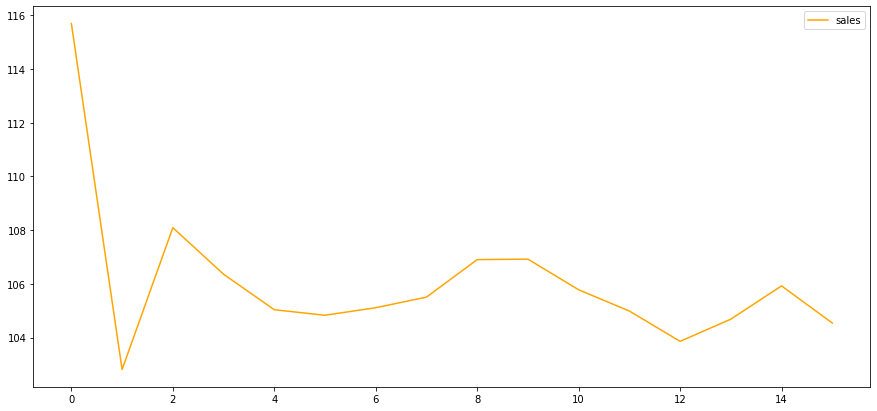

In [25]:
graf = y_pred_grafica.groupby('date').mean()['sales'].to_frame().reset_index()
graf.plot.line(figsize=(15,7), c = 'orange');

In [26]:
y_pred.to_csv('submission.csv', index = False)